# The Statistician: XGBoost
1000 estimators, lr 0.05, max depth 6, early stopping 50 rounds. Binary Human vs AI on 26 handcrafted features.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, precision_recall_curve)
from sklearn.calibration import calibration_curve
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
sns.set_context("notebook")
plt.rcParams['figure.dpi'] = 100
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

## Data loading and splitting
70/15/15 stratified by class x author.

In [2]:
source_path = '../../data_analysis/data.parquet'
df_raw = pd.read_parquet(source_path)

print(f"Loaded {len(df_raw)} rows")
print(f"\nClass distribution:")
print(df_raw['class'].value_counts().sort_index())

features_expanded = pd.json_normalize(df_raw['feature_cache'])

if 'function_word_pca' in features_expanded.columns and 'function_word_pca.dim1' not in features_expanded.columns:
    pca_features = pd.json_normalize(features_expanded['function_word_pca'])
    pca_features.columns = ['function_word_pca.' + c for c in pca_features.columns]
    features_expanded = pd.concat([features_expanded.drop('function_word_pca', axis=1), pca_features], axis=1)

meta_cols = ['id', 'class', 'topic', 'text']
if 'origin_ref' in df_raw.columns:
    meta_cols.append('origin_ref')

df_processed = pd.concat([
    df_raw[meta_cols].reset_index(drop=True),
    features_expanded.reset_index(drop=True)
], axis=1)

df_processed.rename(columns={'class': 'class_label'}, inplace=True)

print(f"\nProcessed shape: {df_processed.shape}")
print(f"Feature columns: {df_processed.shape[1] - len(meta_cols)}")
df_processed.head(2)

Loaded 1508 rows

Class distribution:
class
1    500
2    504
3    504
Name: count, dtype: int64

Processed shape: (1508, 32)
Feature columns: 28


,id,class_label,topic,text,adj_noun_ratio,author,avg_sent_length,book_title,discourse_density_per_100_words,fk_grade,hapax_5k,mtld,n_tokens,n_types,persona_mimicked,punct_apos,punct_apos_curly,punct_asterisk,punct_colon,punct_emdash,punct_exclamation,punct_hyphen,punct_paren_open,punct_question,punct_quote,punct_semicolon,sent_len_std,tree_depth,ttr,word_count,function_word_pca.dim1,function_word_pca.dim2
0,453f7899-867b-4953-8e06-b205c78dc57f,1,Society & Politics,"Thirdly, for that that concerns clerks and min...",0.313725,Bacon,25.714286,The Essays,0.552486,11.183788,88,66.672088,181,111,None,0.0,0.0,0.0,0.000000,0.0,0.0,0.923361,0.923361,0.0,0.0,4.616805,13.043100,6.000000,0.613260,180,0.119352,-0.001291
1,9c792522-5930-4f31-87cd-09caf5c923c5,1,Religion & Spirit,RELIGION being the chief band of human society...,0.289474,Bacon,23.142857,The Essays,1.234568,10.115961,66,49.401907,162,93,None,0.0,0.0,0.0,1.091703,0.0,0.0,0.000000,1.091703,0.0,0.0,4.366812,6.104532,6.857143,0.574074,162,-0.000951,0.014600


In [3]:
df_processed['strat_key'] = df_processed['class_label'].astype(str) + "_" + df_processed['author'].astype(str)

train_val, test = train_test_split(df_processed, test_size=0.15, stratify=df_processed['strat_key'], random_state=42)
train, val = train_test_split(train_val, test_size=0.15/0.85, stratify=train_val['strat_key'], random_state=42)

train.to_parquet('train.parquet', index=False)
val.to_parquet('validate.parquet', index=False)
test.to_parquet('test.parquet', index=False)

print(f"Train: {len(train)} ({len(train)/len(df_processed)*100:.1f}%)")
print(f"Val:   {len(val)} ({len(val)/len(df_processed)*100:.1f}%)")
print(f"Test:  {len(test)} ({len(test)/len(df_processed)*100:.1f}%)")

Train: 1054 (69.9%)
Val:   227 (15.1%)
Test:  227 (15.1%)


## Training

In [4]:
metadata_cols = ['id', 'class_label', 'topic', 'text', 'origin_ref', 'strat_key', 'author', 'book_title', 'persona_mimicked']
feature_cols = [c for c in train.columns if c not in metadata_cols and pd.api.types.is_numeric_dtype(train[c])]

print(f"Using {len(feature_cols)} numerical features:")
print(feature_cols)

X_train = train[feature_cols].values
y_train = (train['class_label'] - 1).values

X_val = val[feature_cols].values
y_val = (val['class_label'] - 1).values

X_test = test[feature_cols].values
y_test = (test['class_label'] - 1).values

print(f"\nX_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

Using 25 numerical features:
['adj_noun_ratio', 'avg_sent_length', 'discourse_density_per_100_words', 'fk_grade', 'hapax_5k', 'mtld', 'n_tokens', 'n_types', 'punct_apos', 'punct_apos_curly', 'punct_asterisk', 'punct_colon', 'punct_emdash', 'punct_exclamation', 'punct_hyphen', 'punct_paren_open', 'punct_question', 'punct_quote', 'punct_semicolon', 'sent_len_std', 'tree_depth', 'ttr', 'word_count', 'function_word_pca.dim1', 'function_word_pca.dim2']

X_train shape: (1054, 25)
X_val shape: (227, 25)
X_test shape: (227, 25)


In [5]:
model_v1 = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    random_state=42,
    early_stopping_rounds=50,
    n_jobs=-1,
    eval_metric='mlogloss'
)

eval_set = [(X_train, y_train), (X_val, y_val)]
model_v1.fit(X_train, y_train, eval_set=eval_set, verbose=False)

print(f"Best iteration: {model_v1.best_iteration}")
print(f"Best validation logloss: {model_v1.best_score:.4f}")

Best iteration: 320
Best validation logloss: 0.2258


## Evaluation
Binary performance, calibration, subgroup analysis, feature importance.

=== Validation Performance ===
Binary Accuracy: 93.83%
ROC AUC Score:   0.9814


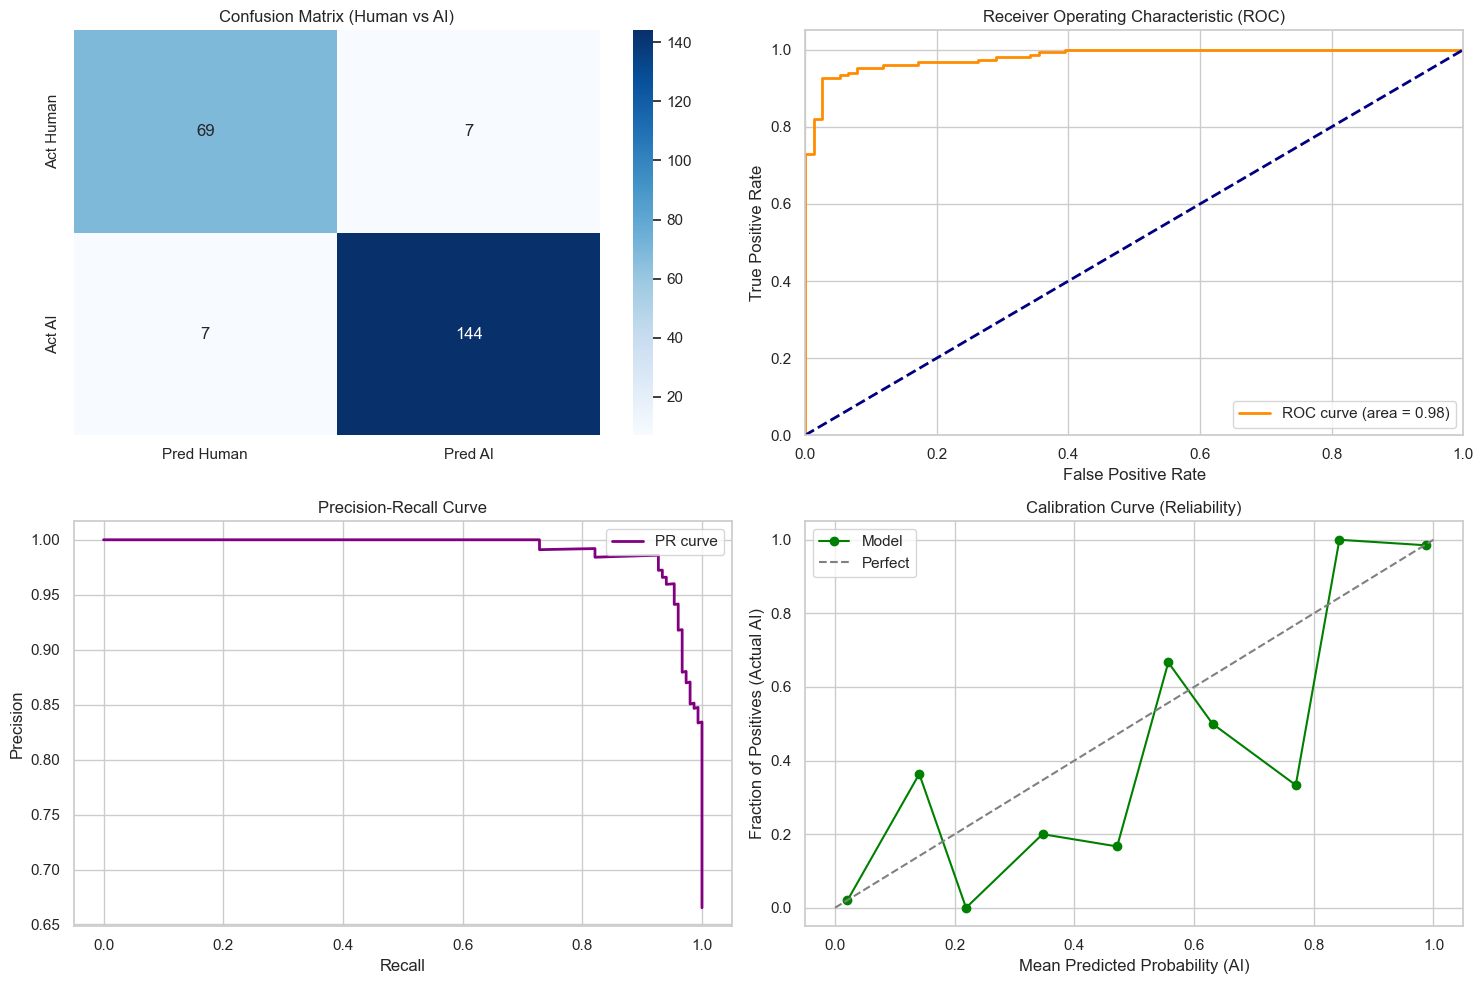

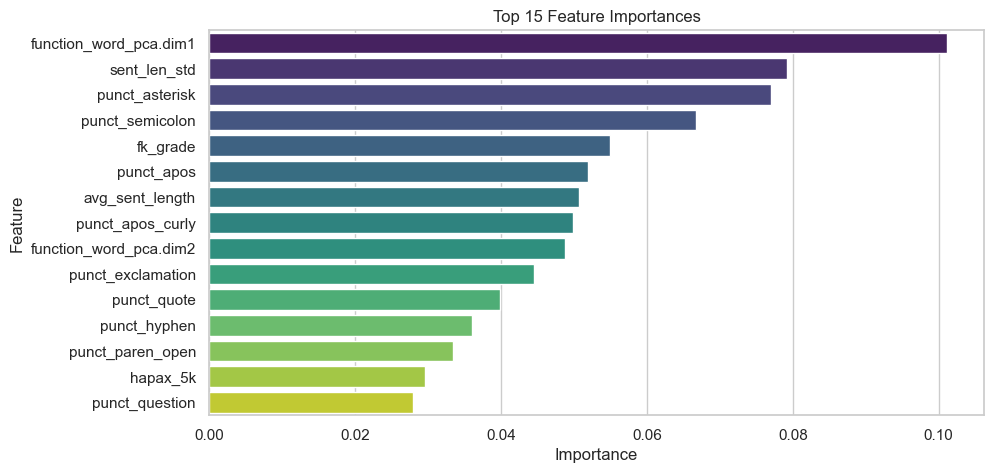

In [6]:
def evaluate_model(model, X, y_true, features, df_meta, split_name='Validation'):
    y_prob = model.predict_proba(X)
    y_pred = model.predict(X)

    y_true_bin = (y_true > 0).astype(int)

    y_prob_ai = y_prob[:, 1] + y_prob[:, 2]
    y_pred_bin = (y_prob_ai > 0.5).astype(int)

    acc = accuracy_score(y_true_bin, y_pred_bin)
    auc = roc_auc_score(y_true_bin, y_prob_ai)

    print(f"=== {split_name} Performance ===")
    print(f"Binary Accuracy: {acc:.2%}")
    print(f"ROC AUC Score:   {auc:.4f}")

    df_results = df_meta.copy()
    df_results['pred_class_orig'] = y_pred + 1
    df_results['pred_prob_ai'] = y_prob_ai
    df_results['pred_binary'] = y_pred_bin
    df_results['actual_binary'] = y_true_bin
    df_results['correct'] = df_results['pred_binary'] == df_results['actual_binary']

    fig = plt.figure(figsize=(15, 10))
    gs = fig.add_gridspec(2, 2)

    ax1 = fig.add_subplot(gs[0, 0])
    cm = confusion_matrix(y_true_bin, y_pred_bin)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Pred Human', 'Pred AI'], 
                yticklabels=['Act Human', 'Act AI'], ax=ax1)
    ax1.set_title(f'Confusion Matrix (Human vs AI)')

    ax2 = fig.add_subplot(gs[0, 1])
    fpr, tpr, _ = roc_curve(y_true_bin, y_prob_ai)
    ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('Receiver Operating Characteristic (ROC)')
    ax2.legend(loc="lower right")

    ax3 = fig.add_subplot(gs[1, 0])
    precision, recall, _ = precision_recall_curve(y_true_bin, y_prob_ai)
    ax3.plot(recall, precision, color='purple', lw=2, label='PR curve')
    ax3.set_xlabel('Recall')
    ax3.set_ylabel('Precision')
    ax3.set_title('Precision-Recall Curve')
    ax3.legend()

    ax4 = fig.add_subplot(gs[1, 1])
    prob_true, prob_pred = calibration_curve(y_true_bin, y_prob_ai, n_bins=10)
    ax4.plot(prob_pred, prob_true, marker='o', label='Model', color='green')
    ax4.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect')
    ax4.set_xlabel('Mean Predicted Probability (AI)')
    ax4.set_ylabel('Fraction of Positives (Actual AI)')
    ax4.set_title('Calibration Curve (Reliability)')
    ax4.legend()

    plt.tight_layout()
    plt.show()

    importance = model.feature_importances_
    feat_df = pd.DataFrame({'Feature': features, 'Importance': importance}).sort_values('Importance', ascending=False)

    plt.figure(figsize=(10, 5))
    sns.barplot(data=feat_df.head(15), x='Importance', y='Feature', palette='viridis')
    plt.title(f'Top 15 Feature Importances')
    plt.show()

    return df_results

results = evaluate_model(model_v1, X_val, y_val, feature_cols, val)

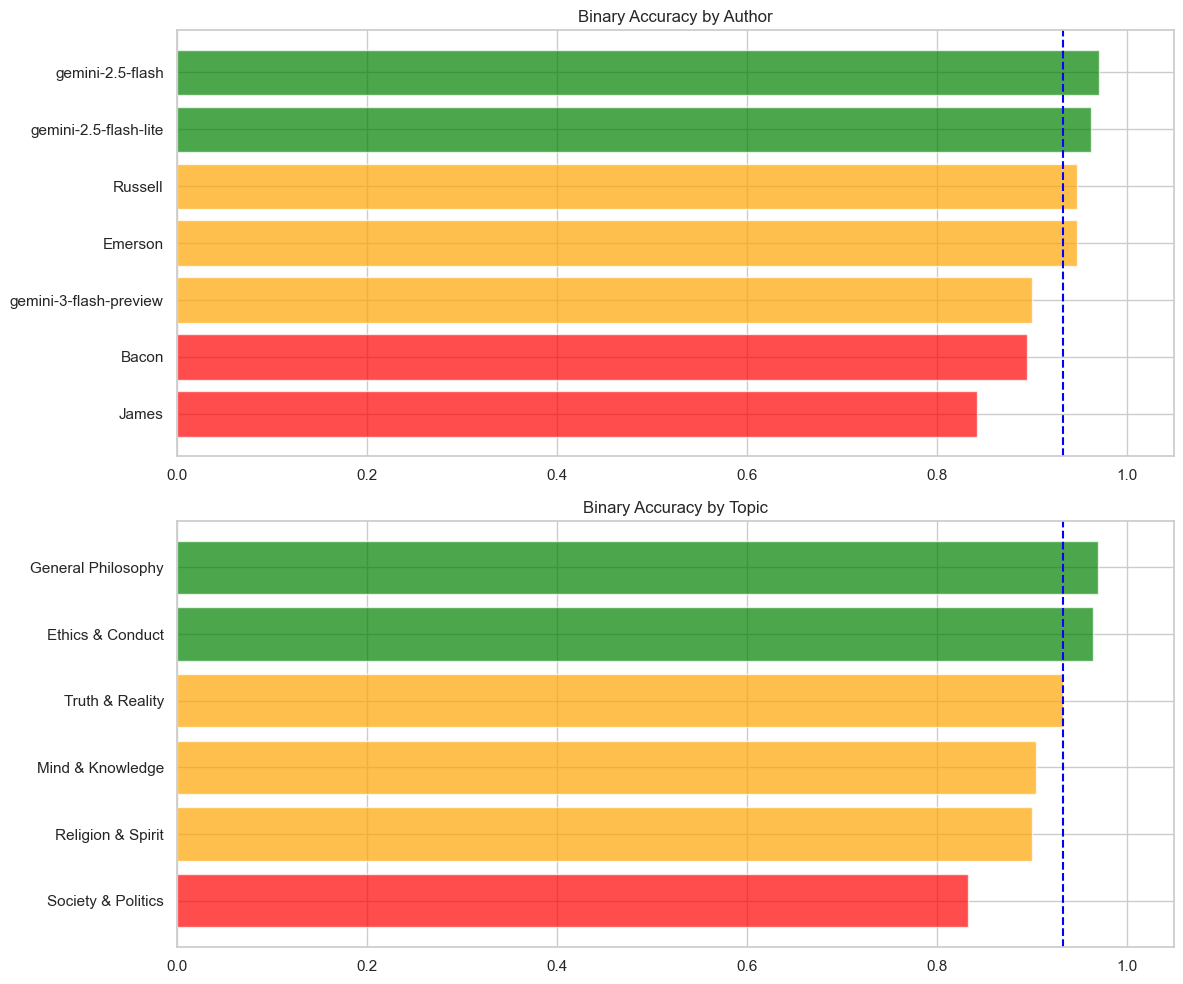

Likely 'Imposter' Candidates (Low Accuracy Authors):
                        accuracy  confidence_ai  confidence_human  count
author                                                                  
James                   0.842105            NaN          0.792993   19.0
Bacon                   0.894737            NaN          0.833796   19.0
gemini-3-flash-preview  0.900000       0.911102               NaN   30.0
Emerson                 0.947368            NaN          0.869533   19.0
Russell                 0.947368            NaN          0.885324   19.0


In [7]:
def analyze_subgroups(results):
    results['actual_binary'] = (results['class_label'] > 1).astype(int)

    author_metrics = results.groupby('author').apply(
        lambda x: pd.Series({
            'accuracy': accuracy_score(x['actual_binary'], x['pred_binary']),
            'confidence_ai': x[x['actual_binary']==1]['pred_prob_ai'].mean(),
            'confidence_human': 1 - x[x['actual_binary']==0]['pred_prob_ai'].mean(),
            'count': len(x)
        })
    ).sort_values('accuracy')

    topic_metrics = results.groupby('topic').apply(
        lambda x: pd.Series({
            'accuracy': accuracy_score(x['actual_binary'], x['pred_binary']),
            'count': len(x)
        })
    ).sort_values('accuracy')

    fig, axes = plt.subplots(2, 1, figsize=(12, 10))

    colors = ['red' if x < 0.9 else 'orange' if x < 0.95 else 'green' for x in author_metrics['accuracy']]
    axes[0].barh(author_metrics.index, author_metrics['accuracy'], color=colors, alpha=0.7)
    axes[0].axvline(0.933, color='blue', linestyle='--', label='Avg')
    axes[0].set_title('Binary Accuracy by Author')
    axes[0].set_xlim(0, 1.05)

    colors_t = ['red' if x < 0.9 else 'orange' if x < 0.95 else 'green' for x in topic_metrics['accuracy']]
    axes[1].barh(topic_metrics.index, topic_metrics['accuracy'], color=colors_t, alpha=0.7)
    axes[1].axvline(0.933, color='blue', linestyle='--', label='Avg')
    axes[1].set_title('Binary Accuracy by Topic')
    axes[1].set_xlim(0, 1.05)

    plt.tight_layout()
    plt.show()

    print("Likely 'Imposter' Candidates (Low Accuracy Authors):")
    print(author_metrics.head(5))

analyze_subgroups(results)

In [8]:
fp_errors = results[(results['class_label'] == 1) & (results['pred_binary'] == 1)].sort_values('pred_prob_ai', ascending=False)

if len(fp_errors) > 0:
    print(f"Found {len(fp_errors)} False Positives")
    print("\nTop 3 Most Confident False Positives:")
    
    for idx, row in fp_errors.head(3).iterrows():
        print(f"\n--- ID: {row['id']} ---")
        print(f"Author: {row['author']}")
        print(f"Topic: {row['topic']}")
        print(f"Model Confidence (AI): {row['pred_prob_ai']:.4f}")
        print(f"Text Snippet: {row['text'][:300]}...")
        
        human_means = train[train['class_label']==1][feature_cols].mean()
        
        print("\nFeature Deviations (Z-score vs Human Mean):")
        for feat in ['punct_semicolon', 'function_word_pca.dim1', 'punct_asterisk']:
             if feat in row:
                 val = row[feat]
                 mean = human_means[feat]
                 std = train[train['class_label']==1][feat].std()
                 z = (val - mean) / (std + 1e-9)
                 print(f"  {feat}: {val:.4f} (Human Mean: {mean:.4f}, Z: {z:.2f})")

else:
    print("No False Positives found!")

Found 7 False Positives

Top 3 Most Confident False Positives:

--- ID: 75499581-a5b0-4868-8ef6-20b89effea8d ---
Author: Russell
Topic: Mind & Knowledge
Model Confidence (AI): 0.9741
Text Snippet: Thus the greater part of what would commonly pass as knowledge is more or less probable opinion. In regard to probable opinion, we can derive great assistance from coherence, which we rejected as the definition of truth, but may often use as a criterion. A body of individually probable opinions, if ...

Feature Deviations (Z-score vs Human Mean):
  punct_semicolon: 0.0000 (Human Mean: 2.5677, Z: -0.79)
  function_word_pca.dim1: -0.0633 (Human Mean: -0.0350, Z: -0.46)
  punct_asterisk: 0.0000 (Human Mean: 0.0327, Z: -0.08)

--- ID: 8d181788-7784-477f-96a2-7a9e020e711d ---
Author: Bacon
Topic: Religion & Spirit
Model Confidence (AI): 0.9465
Text Snippet: Surely this is to bring down the Holy Ghost, instead of the likeness of a dove, in the shape of a vulture or raven; and set, out of the bark o

## Test set

=== Test Performance ===
Binary Accuracy: 92.07%
ROC AUC Score:   0.9745


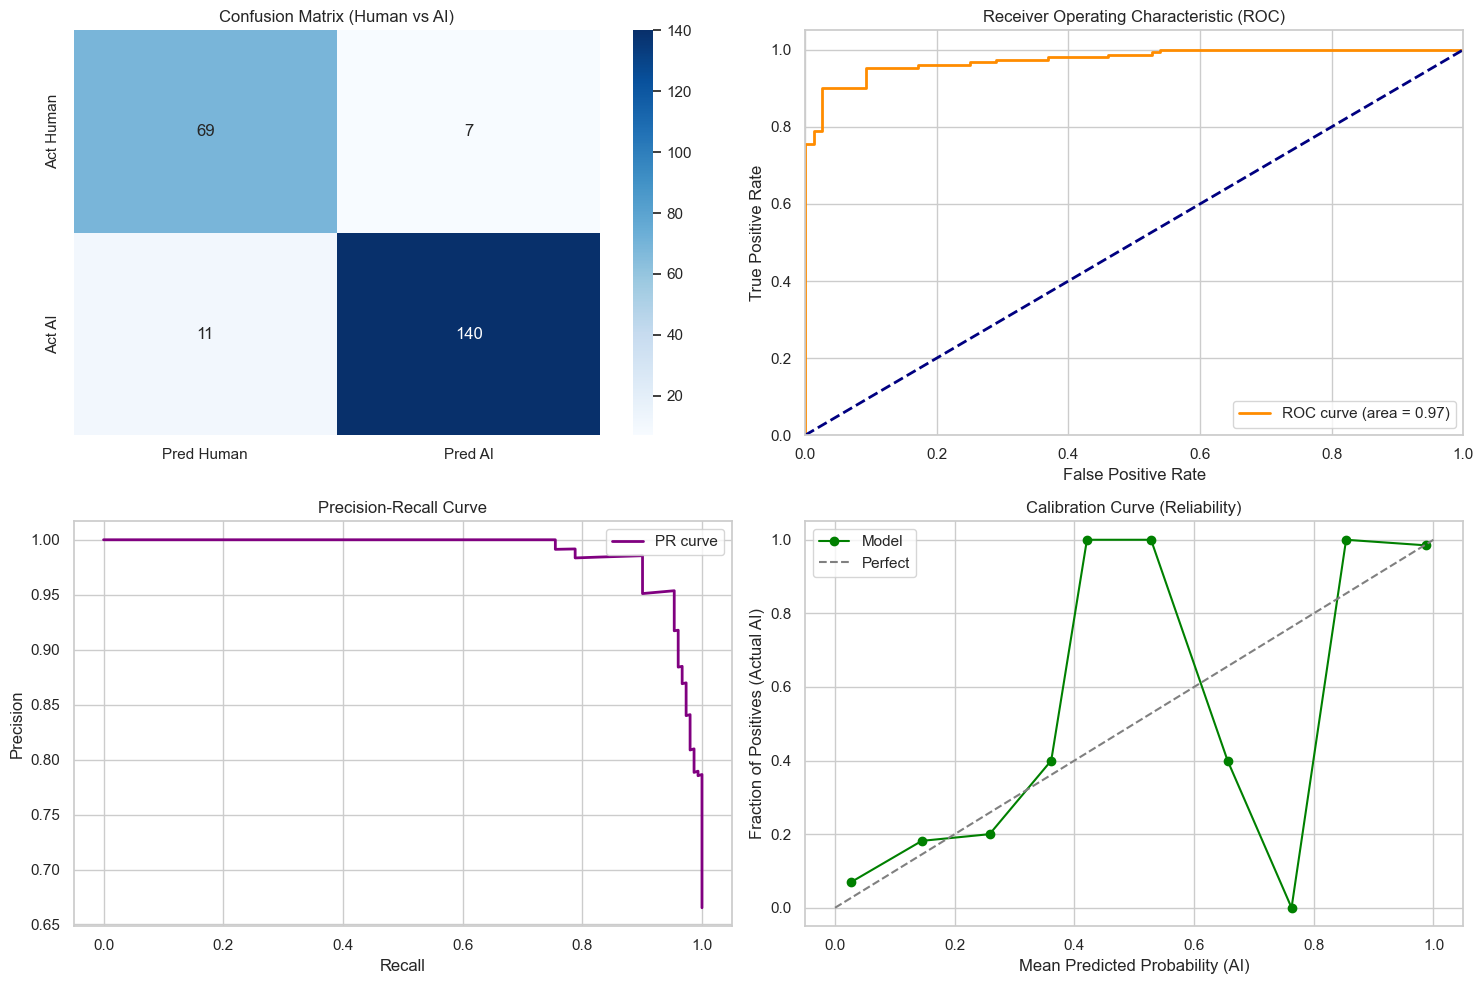

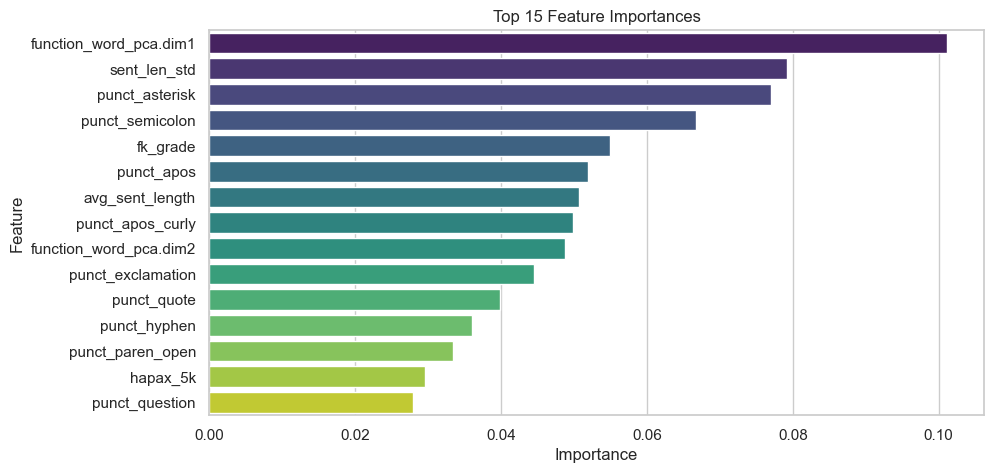

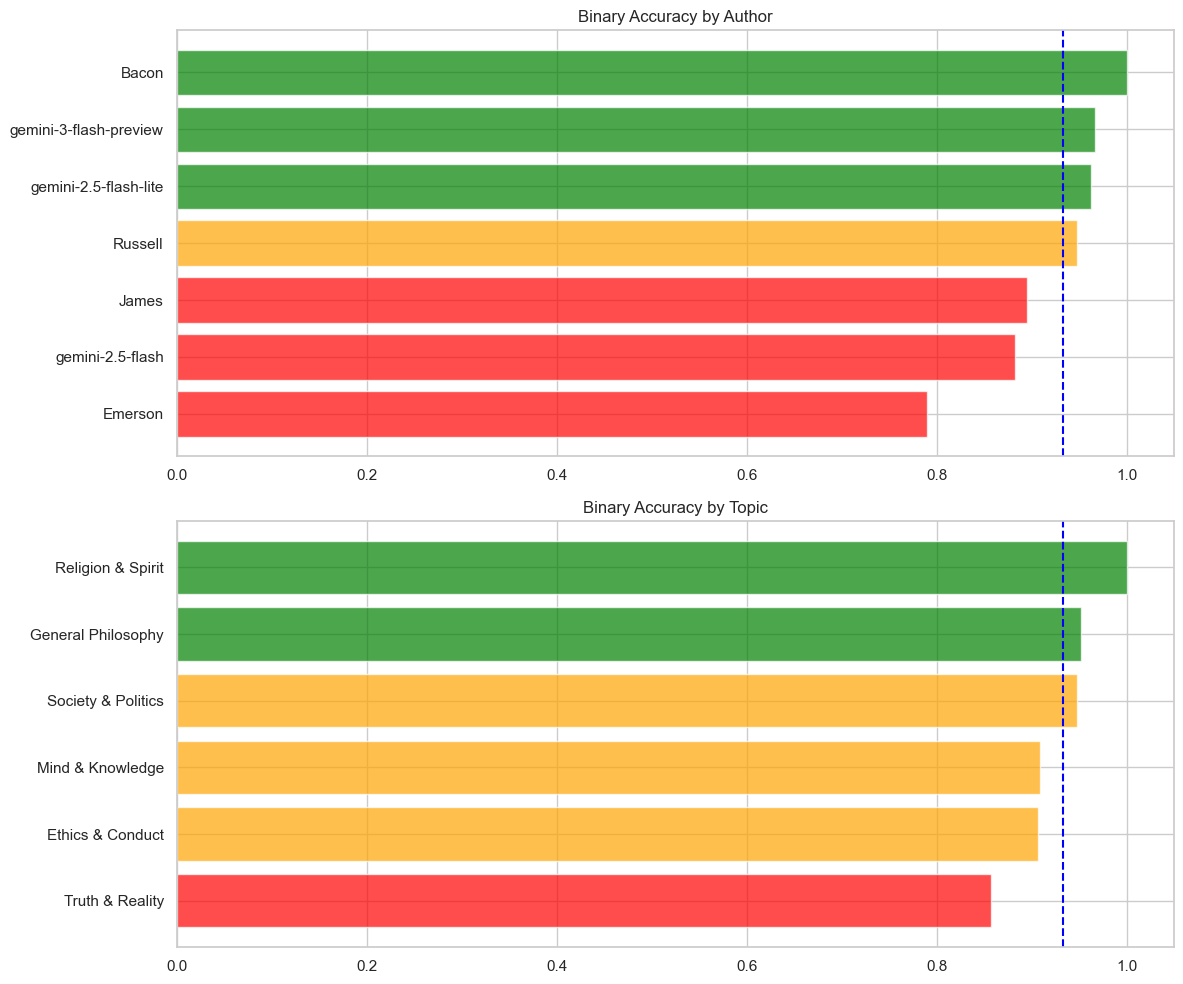

Likely 'Imposter' Candidates (Low Accuracy Authors):
                       accuracy  confidence_ai  confidence_human  count
author                                                                 
Emerson                0.789474            NaN          0.763124   19.0
gemini-2.5-flash       0.882353       0.875585               NaN   68.0
James                  0.894737            NaN          0.850516   19.0
Russell                0.947368            NaN          0.902262   19.0
gemini-2.5-flash-lite  0.962264       0.944972               NaN   53.0


In [9]:
results_test = evaluate_model(model_v1, X_test, y_test, feature_cols, test, split_name='Test')
analyze_subgroups(results_test)

## Feature importance
Permutation importance + feature-target correlations.

In [10]:
from sklearn.inspection import permutation_importance

y_test_binary = (y_test > 0).astype(int)
y_train_binary = (y_train > 0).astype(int)

xgb_importance = pd.DataFrame({
    'Feature': feature_cols,
    'XGB_Gain': model_v1.feature_importances_
}).sort_values('XGB_Gain', ascending=False)

print("XGBoost Gain Importance:")
print("\nTop 15 Features by Gain:")
print(xgb_importance.head(15).to_string(index=False))

print("\nFeature-Target Correlations:")

correlations = []
for i, feat in enumerate(feature_cols):
    corr = np.corrcoef(X_train[:, i], y_train_binary)[0, 1]
    correlations.append({'Feature': feat, 'Correlation': corr, 'Abs_Corr': abs(corr)})

corr_df = pd.DataFrame(correlations).sort_values('Abs_Corr', ascending=False)
print("\nTop 15 Features by |Correlation| with AI label:")
print(corr_df.head(15).to_string(index=False))

merged_importance = xgb_importance.merge(corr_df[['Feature', 'Correlation', 'Abs_Corr']], on='Feature')
merged_importance['Combined_Rank'] = merged_importance['XGB_Gain'].rank(ascending=False) + merged_importance['Abs_Corr'].rank(ascending=False)
merged_importance = merged_importance.sort_values('Combined_Rank')

print("\nCombined ranking (Gain + Correlation):")
print(merged_importance.head(10).to_string(index=False))

XGBoost Gain Importance:

Top 15 Features by Gain:
               Feature  XGB_Gain
function_word_pca.dim1  0.101172
          sent_len_std  0.079237
        punct_asterisk  0.077019
       punct_semicolon  0.066704
              fk_grade  0.054932
            punct_apos  0.051939
       avg_sent_length  0.050673
      punct_apos_curly  0.049918
function_word_pca.dim2  0.048830
     punct_exclamation  0.044563
           punct_quote  0.039918
          punct_hyphen  0.036068
      punct_paren_open  0.033428
              hapax_5k  0.029574
        punct_question  0.027983

Feature-Target Correlations:

Top 15 Features by |Correlation| with AI label:
               Feature  Correlation  Abs_Corr
          sent_len_std    -0.476577  0.476577
       punct_semicolon    -0.397673  0.397673
                   ttr     0.377546  0.377546
              hapax_5k     0.375148  0.375148
function_word_pca.dim2     0.333567  0.333567
                  mtld     0.304950  0.304950
            punct_ap

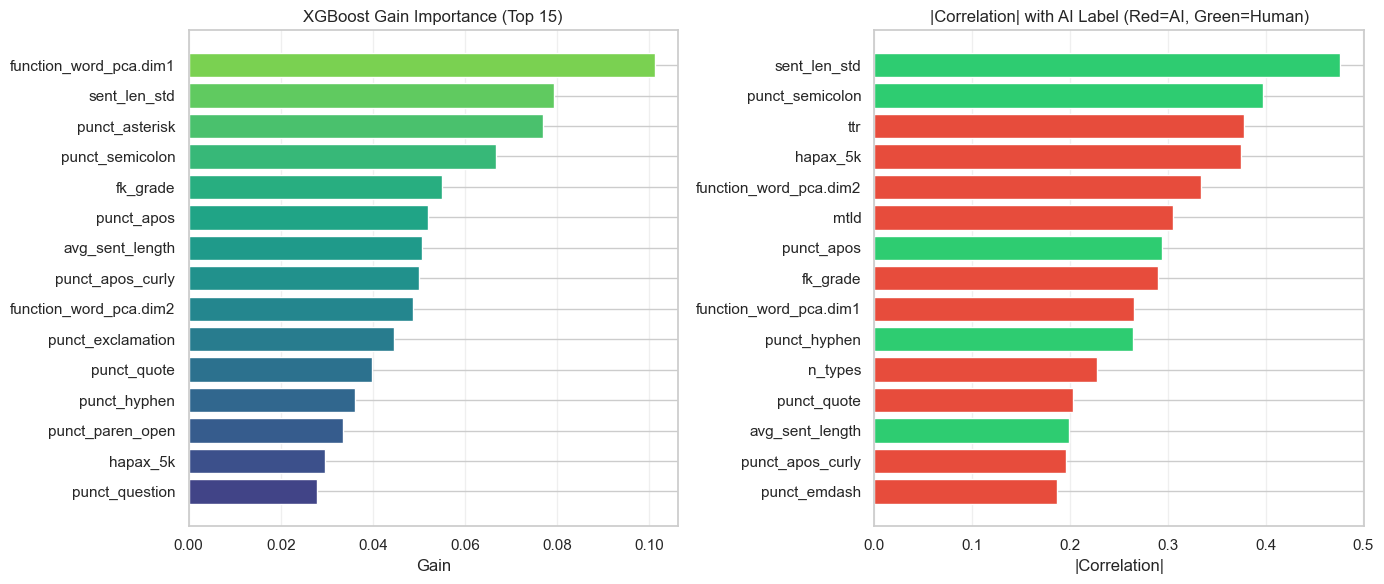

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

top_gain = xgb_importance.head(15)
colors_gain = plt.cm.viridis(np.linspace(0.8, 0.2, len(top_gain)))
axes[0].barh(top_gain['Feature'], top_gain['XGB_Gain'], color=colors_gain)
axes[0].invert_yaxis()
axes[0].set_title('XGBoost Gain Importance (Top 15)', fontsize=12)
axes[0].set_xlabel('Gain')
axes[0].grid(axis='x', alpha=0.3)

top_corr = corr_df.head(15)
colors_corr = ['#e74c3c' if c > 0 else '#2ecc71' for c in top_corr['Correlation']]
axes[1].barh(top_corr['Feature'], top_corr['Abs_Corr'], color=colors_corr)
axes[1].invert_yaxis()
axes[1].set_title('|Correlation| with AI Label (Red=AI, Green=Human)', fontsize=12)
axes[1].set_xlabel('|Correlation|')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('feature_importance_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

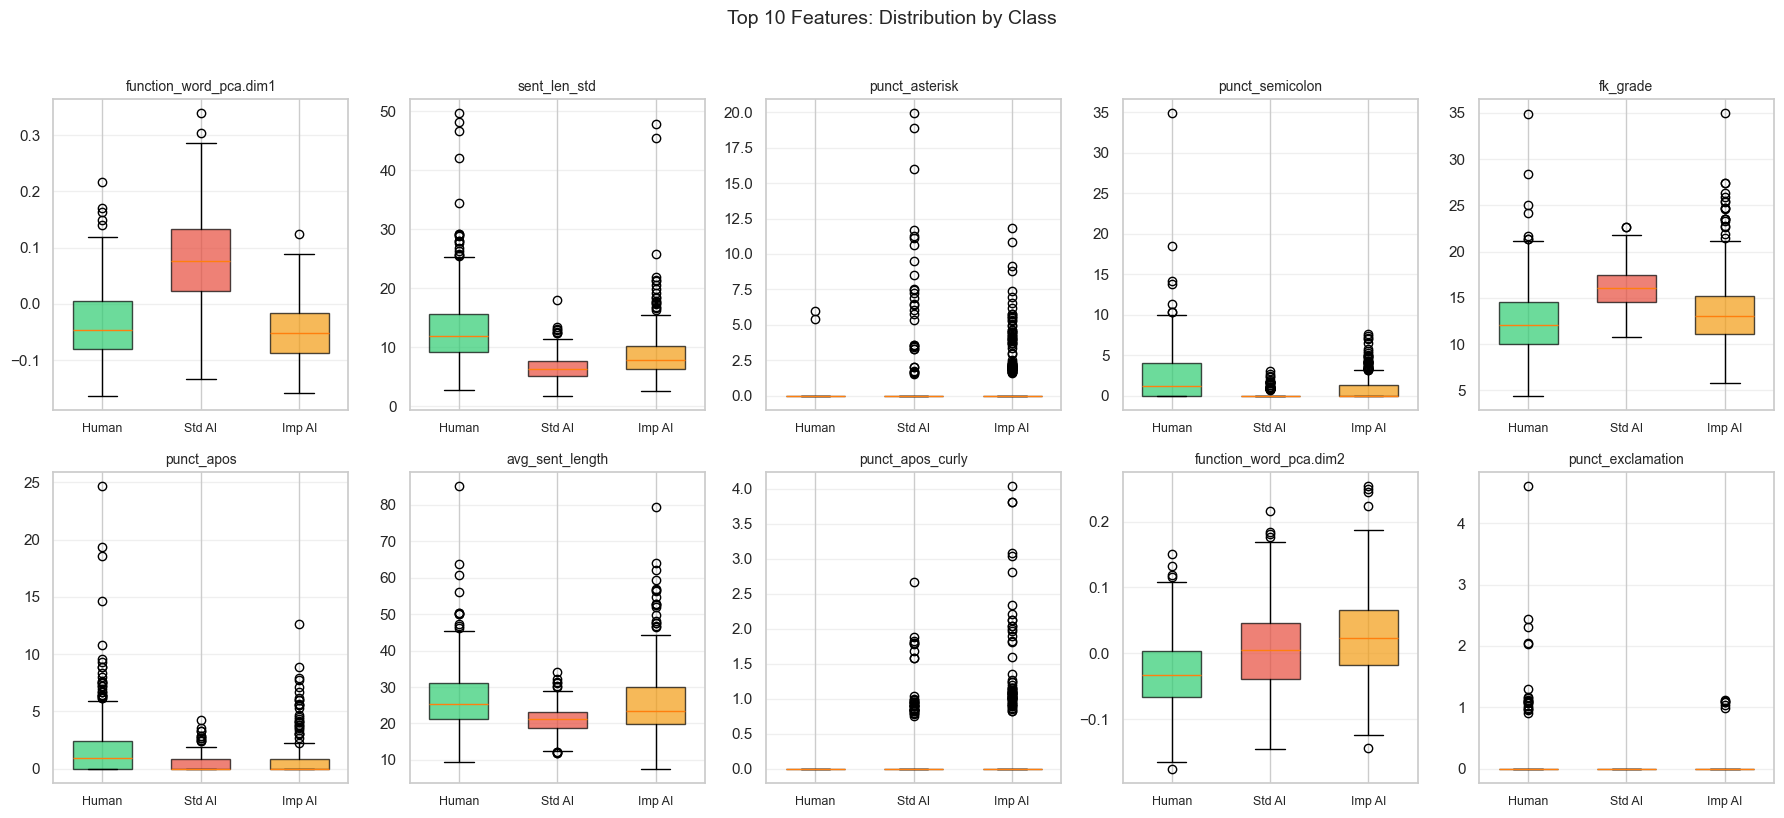

In [12]:
human_means = train[train['class_label'] == 1][feature_cols].mean()
std_ai_means = train[train['class_label'] == 2][feature_cols].mean()
imp_ai_means = train[train['class_label'] == 3][feature_cols].mean()

comparison_df = pd.DataFrame({
    'Feature': feature_cols,
    'Human': human_means.values,
    'Standard_AI': std_ai_means.values,
    'Imposter_AI': imp_ai_means.values,
    'XGB_Importance': xgb_importance.set_index('Feature').loc[feature_cols]['XGB_Gain'].values
})

for feat in feature_cols:
    h_vals = train[train['class_label'] == 1][feat]
    ai_vals = train[train['class_label'] == 2][feat]
    pooled_std = np.sqrt((h_vals.std()**2 + ai_vals.std()**2) / 2)
    comparison_df.loc[comparison_df['Feature'] == feat, 'Effect_Size_d'] = (ai_vals.mean() - h_vals.mean()) / (pooled_std + 1e-9)

comparison_df = comparison_df.sort_values('XGB_Importance', ascending=False)

top_10_features = comparison_df.head(10)['Feature'].tolist()

fig, axes = plt.subplots(2, 5, figsize=(18, 8))
axes = axes.flatten()

for i, feat in enumerate(top_10_features):
    ax = axes[i]
    
    h_data = train[train['class_label'] == 1][feat]
    ai_data = train[train['class_label'] == 2][feat]
    imp_data = train[train['class_label'] == 3][feat]
    
    data = [h_data, ai_data, imp_data]
    bp = ax.boxplot(data, positions=[0, 1, 2], widths=0.6, patch_artist=True)
    
    colors = ['#2ecc71', '#e74c3c', '#f39c12']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['Human', 'Std AI', 'Imp AI'], fontsize=9)
    ax.set_title(feat, fontsize=10)
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Top 10 Features: Distribution by Class', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

In [13]:
print("Feature interpretation:")

top_features = comparison_df.head(10)

for _, row in top_features.iterrows():
    feat = row['Feature']
    h_val = row['Human']
    ai_val = row['Standard_AI']
    imp_val = row['Imposter_AI']
    d = row['Effect_Size_d']
    
    if d > 0.5:
        direction = "AI HIGHER"
    elif d < -0.5:
        direction = "Human HIGHER"
    else:
        direction = "~Similar"
    
    print(f"\n{feat}")
    print(f"  Human Mean: {h_val:.4f}")
    print(f"  Std AI Mean: {ai_val:.4f}")
    print(f"  Imp AI Mean: {imp_val:.4f}")
    print(f"  Effect Size (d): {d:+.2f} ({direction})")
    
    if 'punct_semicolon' in feat:
        print(f"  Humans use semicolons {h_val/ai_val:.1f}x more than Standard AI")
    elif 'mtld' in feat:
        print(f"  AI maintains {ai_val/h_val:.1f}x higher lexical diversity")
    elif 'sent_len_std' in feat:
        print(f"  Human sentence length varies {h_val/ai_val:.1f}x more")
    elif 'fk_grade' in feat:
        print(f"  AI writes at +{ai_val-h_val:.1f} grade levels higher")
    elif 'ttr' in feat:
        print(f"  AI has {(ai_val-h_val)/h_val*100:.1f}% higher type-token ratio")

Feature interpretation:

function_word_pca.dim1
  Human Mean: -0.0350
  Std AI Mean: 0.0801
  Imp AI Mean: -0.0488
  Effect Size (d): +1.51 (AI HIGHER)

sent_len_std
  Human Mean: 13.3119
  Std AI Mean: 6.5371
  Imp AI Mean: 8.9179
  Effect Size (d): -1.39 (Human HIGHER)
  Human sentence length varies 2.0x more

punct_asterisk
  Human Mean: 0.0327
  Std AI Mean: 0.5919
  Imp AI Mean: 0.8162
  Effect Size (d): +0.32 (~Similar)

punct_semicolon
  Human Mean: 2.5677
  Std AI Mean: 0.2330
  Imp AI Mean: 1.0178
  Effect Size (d): -1.00 (Human HIGHER)
  Humans use semicolons 11.0x more than Standard AI

fk_grade
  Human Mean: 12.5590
  Std AI Mean: 16.0691
  Imp AI Mean: 13.6071
  Effect Size (d): +1.14 (AI HIGHER)
  AI writes at +3.5 grade levels higher

punct_apos
  Human Mean: 1.8140
  Std AI Mean: 0.3832
  Imp AI Mean: 0.6673
  Effect Size (d): -0.67 (Human HIGHER)

avg_sent_length
  Human Mean: 26.9260
  Std AI Mean: 21.1071
  Imp AI Mean: 25.8683
  Effect Size (d): -0.85 (Human HIGHER)

In [14]:
def explain_prediction(model, X_single, feature_names, df_means, label='Sample'):
    prob = model.predict_proba(X_single.reshape(1, -1))[0]
    prob_ai = prob[1] + prob[2]
    pred_class = 'AI' if prob_ai > 0.5 else 'Human'
    
    print(f"\n{label}")
    print(f"Prediction: {pred_class} (P(AI) = {prob_ai:.4f})")
    print(f"Class probabilities: Human={prob[0]:.3f}, Std AI={prob[1]:.3f}, Imp AI={prob[2]:.3f}")
    
    human_means = df_means['Human']
    ai_means = df_means['Standard_AI']
    
    print(f"\nFeatures pushing toward AI (value >> human mean):")
    deviations = []
    for i, feat in enumerate(feature_names):
        val = X_single[i]
        h_mean = human_means[feat]
        ai_mean = ai_means[feat]
        
        h_std = train[train['class_label']==1][feat].std()
        z = (val - h_mean) / (h_std + 1e-9)
        
        dist_h = abs(val - h_mean)
        dist_ai = abs(val - ai_mean)
        toward_ai = 1 if dist_h > dist_ai else 0
        
        deviations.append({
            'feature': feat,
            'value': val,
            'human_mean': h_mean,
            'ai_mean': ai_mean,
            'z_score': z,
            'toward_ai': toward_ai
        })
    
    deviations = sorted(deviations, key=lambda x: abs(x['z_score']) * x['toward_ai'], reverse=True)
    
    ai_features = [d for d in deviations if d['toward_ai']][:5]
    for d in ai_features:
        print(f"  {d['feature']}: {d['value']:.3f} (Human={d['human_mean']:.3f}, Z={d['z_score']:+.1f})")
    
    print(f"\nFeatures pushing toward Human:")
    human_features = [d for d in deviations if not d['toward_ai']][:5]
    for d in human_features:
        print(f"  {d['feature']}: {d['value']:.3f} (Human={d['human_mean']:.3f}, Z={d['z_score']:+.1f})")
    
    return prob_ai

means_df = pd.DataFrame({
    'Human': train[train['class_label'] == 1][feature_cols].mean(),
    'Standard_AI': train[train['class_label'] == 2][feature_cols].mean()
})

print("Sample explanations:")

y_prob_test = model_v1.predict_proba(X_test)
prob_ai_test = y_prob_test[:, 1] + y_prob_test[:, 2]

ai_mask = y_test > 0
top_ai_idx = np.where(ai_mask)[0][np.argmax(prob_ai_test[ai_mask])]
explain_prediction(model_v1, X_test[top_ai_idx], feature_cols, means_df, 
                   f"HIGH CONFIDENCE AI (True Class: {'Std AI' if y_test[top_ai_idx]==1 else 'Imp AI'})")

human_mask = y_test == 0
top_human_idx = np.where(human_mask)[0][np.argmin(prob_ai_test[human_mask])]
explain_prediction(model_v1, X_test[top_human_idx], feature_cols, means_df,
                   "HIGH CONFIDENCE HUMAN")

Sample explanations:

HIGH CONFIDENCE AI (True Class: Std AI)
Prediction: AI (P(AI) = 1.0000)
Class probabilities: Human=0.000, Std AI=1.000, Imp AI=0.000

Features pushing toward AI (value >> human mean):
  function_word_pca.dim1: 0.257 (Human=-0.035, Z=+4.7)
  mtld: 164.504 (Human=72.926, Z=+3.5)
  hapax_5k: 102.000 (Human=75.480, Z=+1.8)
  ttr: 0.728 (Human=0.615, Z=+1.8)
  n_types: 118.000 (Human=101.282, Z=+1.4)

Features pushing toward Human:
  discourse_density_per_100_words: 0.617 (Human=0.415, Z=+0.4)
  punct_apos_curly: 0.000 (Human=0.000, Z=+0.0)
  punct_asterisk: 0.000 (Human=0.033, Z=-0.1)
  punct_emdash: 0.000 (Human=0.000, Z=+0.0)
  punct_paren_open: 0.000 (Human=0.205, Z=-0.4)

HIGH CONFIDENCE HUMAN
Prediction: Human (P(AI) = 0.0004)
Class probabilities: Human=1.000, Std AI=0.000, Imp AI=0.000

Features pushing toward AI (value >> human mean):
  mtld: 107.763 (Human=72.926, Z=+1.3)
  word_count: 146.000 (Human=163.218, Z=-1.3)
  ttr: 0.691 (Human=0.615, Z=+1.2)
  n_toke

0.0004217652

## Error analysis
False positives and false negatives with feature deviations.

In [15]:
y_prob_test = model_v1.predict_proba(X_test)
y_prob_ai_test = y_prob_test[:, 1] + y_prob_test[:, 2]
y_pred_bin_test = (y_prob_ai_test > 0.5).astype(int)
y_true_bin_test = (y_test > 0).astype(int)

test_analysis = test.copy().reset_index(drop=True)
test_analysis['prob_ai'] = y_prob_ai_test
test_analysis['pred_binary'] = y_pred_bin_test
test_analysis['actual_binary'] = y_true_bin_test
test_analysis['correct'] = (test_analysis['pred_binary'] == test_analysis['actual_binary'])

false_positives = test_analysis[
    (test_analysis['class_label'] == 1) & 
    (test_analysis['pred_binary'] == 1)
].sort_values('prob_ai', ascending=False)

false_negatives = test_analysis[
    (test_analysis['class_label'] > 1) & 
    (test_analysis['pred_binary'] == 0)
].sort_values('prob_ai', ascending=True)

print("Error analysis:")
print(f"Total Test Samples: {len(test_analysis)}")
print(f"False Positives (Human -> AI): {len(false_positives)} ({len(false_positives)/len(test_analysis)*100:.1f}%)")
print(f"False Negatives (AI -> Human): {len(false_negatives)} ({len(false_negatives)/len(test_analysis)*100:.1f}%)")
print()

if len(false_positives) > 0:
    print("Top 3 False Positives (Humans Misclassified as AI):")
    
    for i, (idx, row) in enumerate(false_positives.head(3).iterrows()):
        print(f"\n--- False Positive #{i+1} ---")
        print(f"ID: {row['id']}")
        print(f"Author: {row['author']}")
        print(f"Topic: {row['topic']}")
        print(f"Model P(AI): {row['prob_ai']:.4f}")
        print(f"\nText Snippet:")
        print(f"  '{row['text'][:400]}...'")
        
        human_train = train[train['class_label'] == 1]
        print(f"\nKey Feature Deviations:")
        
        deviations = []
        for feat in feature_cols:
            h_mean = human_train[feat].mean()
            h_std = human_train[feat].std()
            val = row[feat]
            z_score = (val - h_mean) / (h_std + 1e-9)
            deviations.append((feat, val, h_mean, z_score))
        
        deviations = sorted(deviations, key=lambda x: abs(x[3]), reverse=True)
        
        for feat, val, h_mean, z in deviations[:5]:
            print(f"  {feat}: {val:.4f} (Human Mean: {h_mean:.4f}, Z: {z:+.2f})")
        
        print()

if len(false_negatives) > 0:
    print("Top 3 False Negatives (AI Misclassified as Human):")
    
    for i, (idx, row) in enumerate(false_negatives.head(3).iterrows()):
        print(f"\n--- False Negative #{i+1} ---")
        print(f"ID: {row['id']}")
        print(f"Actual Class: {'Standard AI' if row['class_label']==2 else 'Imposter AI'}")
        print(f"Author/Persona: {row.get('persona_mimicked', row['author'])}")
        print(f"Topic: {row['topic']}")
        print(f"Model P(AI): {row['prob_ai']:.4f}")
        print(f"\nText Snippet:")
        print(f"  '{row['text'][:400]}...'")
        
        ai_train = train[train['class_label'] > 1]
        print(f"\nFeatures Making This Look Human:")
        
        deviations = []
        for feat in feature_cols:
            ai_mean = ai_train[feat].mean()
            ai_std = ai_train[feat].std()
            h_mean = human_train[feat].mean()
            val = row[feat]
            dist_to_human = abs(val - h_mean)
            dist_to_ai = abs(val - ai_mean)
            human_likeness = dist_to_ai / (dist_to_human + 1e-9)
            deviations.append((feat, val, h_mean, ai_mean, human_likeness))
        
        deviations = sorted(deviations, key=lambda x: x[4], reverse=True)
        
        for feat, val, h_mean, ai_mean, likeness in deviations[:5]:
            print(f"  {feat}: {val:.4f} (Human: {h_mean:.4f}, AI: {ai_mean:.4f}, Likeness: {likeness:.2f}x)")
        
        print()

Error analysis:
Total Test Samples: 227
False Positives (Human -> AI): 7 (3.1%)
False Negatives (AI -> Human): 11 (4.8%)

Top 3 False Positives (Humans Misclassified as AI):

--- False Positive #1 ---
ID: b874e17c-3400-4d64-aab3-f1f8fbde4375
Author: Emerson
Topic: Ethics & Conduct
Model P(AI): 0.9679

Text Snippet:
  'This time, like all times, is a very good one, if we but know what to do with it. I read with some joy of the auspicious signs of the coming days, as they glimmer already through poetry and art, through philosophy and science, through church and state. One of these signs is the fact that the same movement which effected the elevation of what was called the lowest class in the state assumed in lite...'

Key Feature Deviations:
  function_word_pca.dim2: 0.0710 (Human Mean: -0.0303, Z: +1.84)
  function_word_pca.dim1: 0.0341 (Human Mean: -0.0350, Z: +1.12)
  tree_depth: 8.1667 (Human Mean: 6.9576, Z: +1.00)
  sent_len_std: 6.9921 (Human Mean: 13.3119, Z: -0.97)
  punct_semic

In [16]:
error_analysis_results = {
    'false_positives': false_positives[['id', 'author', 'topic', 'prob_ai', 'text']].head(10).to_dict('records'),
    'false_negatives': false_negatives[['id', 'class_label', 'topic', 'prob_ai', 'text']].head(10).to_dict('records'),
    'total_fp': len(false_positives),
    'total_fn': len(false_negatives),
    'fp_rate': len(false_positives) / len(test_analysis[test_analysis['class_label'] == 1]),
    'fn_rate': len(false_negatives) / len(test_analysis[test_analysis['class_label'] > 1])
}

import json
with open('error_analysis.json', 'w') as f:
    json.dump(error_analysis_results, f, indent=2, default=str)

print("Saved error_analysis.json")
print(f"  False Positive Rate: {error_analysis_results['fp_rate']:.2%}")
print(f"  False Negative Rate: {error_analysis_results['fn_rate']:.2%}")

Saved error_analysis.json
  False Positive Rate: 9.21%
  False Negative Rate: 7.28%
